In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pandas import Series
from datetime import datetime as dt

In [2]:
train = pd.read_csv('Train_SU63ISt.csv')
test = pd.read_csv('Test_0qrQsBZ.csv')

In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [5]:
train.shape

(18288, 3)

In [6]:
train.Count.sum()

2541266

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


### the data type of our datetime column is object not a date so what we need to do is to convert it into datetime dtype

In [8]:
df_train = train.copy()
df_test = test.copy()

In [9]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M').astype('datetime64')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M').astype('datetime64')
df_train['Datetime'] = pd.to_datetime(df_train.Datetime, format='%d-%m-%Y %H:%M').astype('datetime64')
df_test['Datetime'] = pd.to_datetime(df_test.Datetime, format='%d-%m-%Y %H:%M').astype('datetime64')

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


In [11]:
for i in (df_train, df_test, train, test):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour

In [12]:
df_train.shape

(18288, 7)

In [13]:
df_train['day of week'] = df_train['Datetime'].dt.dayofweek

In [14]:
df_train

,ID,Datetime,Count,year,month,day,Hour,day of week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5
...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3


In [15]:
## Lets see which day our date is of the week.

In [16]:
df_train['day of week'].unique()

array([5, 6, 0, 1, 2, 3, 4], dtype=int64)

In [17]:
# lets make a weekend column as trafic will be higher during weekend

In [18]:
weekend = []
for i in df_train['day of week']:
    if i == 5 or i == 6:
        weekend.append(1)
    else:
        weekend.append(0)

In [19]:
df_train.head()

,ID,Datetime,Count,year,month,day,Hour,day of week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5


<AxesSubplot:xlabel='Hour'>

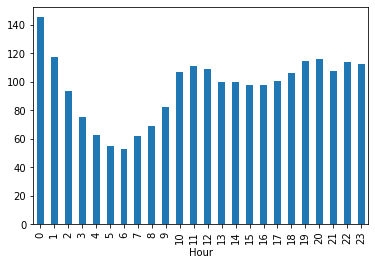

In [20]:
df_train[(df_train['day of week'] == 5)].groupby(['Hour']).Count.mean().plot.bar()

In [21]:
### We can see that there is decreasing trend til from 12 pm to 6 am 

In [22]:
df_train['weekend'] = weekend

In [23]:
# lets look at data on each day of week and how it is distributed.
df_train.groupby(['day of week']).Count.describe()

,count,mean,std,min,25%,50%,75%,max
day of week,,,,,,,,
0,2616.0,157.842508,169.081006,2.0,24.0,90.0,244.0,1054.0
1,2616.0,164.750765,180.587558,2.0,26.0,104.0,250.0,1220.0
2,2616.0,163.234709,177.442067,2.0,22.0,104.0,242.0,1244.0
3,2616.0,155.676606,155.895413,2.0,22.0,104.0,242.0,868.0
4,2592.0,144.722994,147.905977,2.0,28.0,94.0,218.0,968.0
5,2616.0,96.059633,100.471330,2.0,18.0,62.0,140.0,686.0
6,2616.0,90.472477,99.133022,2.0,18.0,54.0,128.0,720.0


<AxesSubplot:xlabel='day of week'>

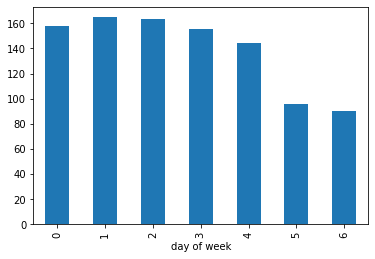

In [24]:
df_train.groupby(['day of week']).Count.mean().plot.bar()

#### We can see that during weekend on a average we have less traffic.

In [25]:
df_train.groupby(['Hour']).Count.describe()

,count,mean,std,min,25%,50%,75%,max
Hour,,,,,,,,
0,762.0,147.695538,139.160659,2.0,28.0,108.0,228.0,686.0
1,762.0,117.868766,111.824076,2.0,24.0,84.0,191.5,596.0
2,762.0,99.753281,98.282930,2.0,20.0,70.0,155.5,580.0
3,762.0,82.422572,82.079253,2.0,18.0,56.0,129.5,604.0
4,762.0,69.375328,69.777030,2.0,14.0,46.0,108.0,458.0
5,762.0,62.102362,63.730172,2.0,12.0,42.0,94.0,412.0
6,762.0,66.776903,71.147420,2.0,12.0,45.0,97.5,646.0
7,762.0,77.443570,82.727519,2.0,14.0,52.0,112.0,498.0
8,762.0,89.181102,91.214445,2.0,16.0,62.0,133.5,558.0


<AxesSubplot:xlabel='Hour'>

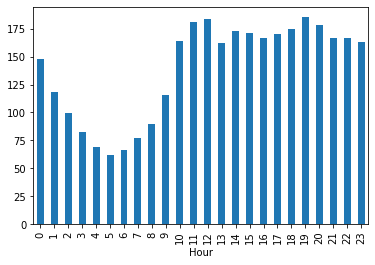

In [26]:
df_train.groupby(['Hour']).Count.mean().plot.bar()

In [27]:
# lets look at how dat is distributed month wise
a =df_train.groupby(['month']).Count.mean()

<AxesSubplot:xlabel='month'>

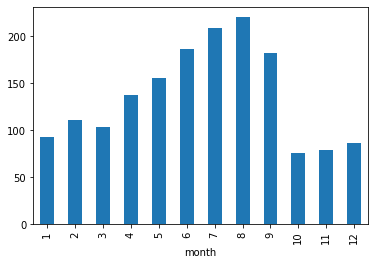

In [28]:
a.plot.bar()

<AxesSubplot:title={'center':'Average no of passenger per hour'}, xlabel='month', ylabel='Count'>

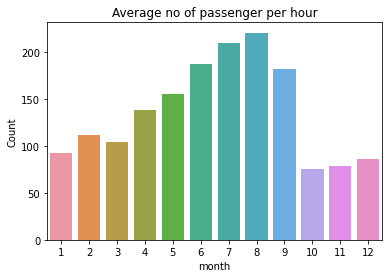

In [29]:
plt.xlabel('month')
plt.title('Average no of passenger per hour')
sns.barplot(x=[i for i in range(1,13)], y=a)

<AxesSubplot:xlabel='year'>

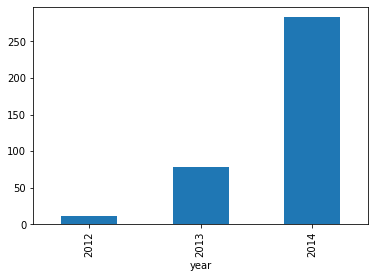

In [30]:
# lets see yearly passenger Count
df_train.groupby(['year']).Count.mean().plot.bar()

In [31]:
ts = df_train.copy()

In [32]:
ts.index = ts['Datetime']

In [33]:
ts = ts.drop('ID', axis=1)

In [34]:
ts.Count

Datetime
2012-08-25 00:00:00      8
2012-08-25 01:00:00      2
2012-08-25 02:00:00      6
2012-08-25 03:00:00      2
2012-08-25 04:00:00      2
                      ... 
2014-09-25 19:00:00    868
2014-09-25 20:00:00    732
2014-09-25 21:00:00    702
2014-09-25 22:00:00    580
2014-09-25 23:00:00    534
Name: Count, Length: 18288, dtype: int64

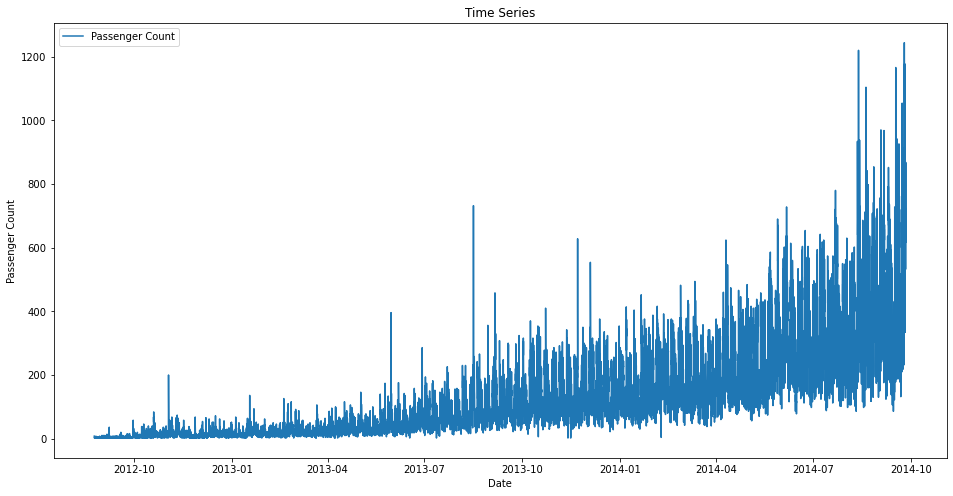

In [35]:
plt.figure(figsize=(16,8))
plt.plot(ts.Count, label='Passenger Count')
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

In [36]:
df_train

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1
...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,0
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,0
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,0
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,0


In [37]:
df_train.drop('ID',axis =1, inplace=True)

In [38]:
df_train.index = df_train.Datetime

In [39]:
df_train

,Datetime,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2012-08-25 04:00:00,2,2012,8,25,4,5,1
...,...,...,...,...,...,...,...,...
2014-09-25 19:00:00,2014-09-25 19:00:00,868,2014,9,25,19,3,0
2014-09-25 20:00:00,2014-09-25 20:00:00,732,2014,9,25,20,3,0
2014-09-25 21:00:00,2014-09-25 21:00:00,702,2014,9,25,21,3,0


In [40]:
hourly = df_train.resample('H').mean()

In [41]:
hourly

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2,2012,8,25,4,5,1
...,...,...,...,...,...,...,...
2014-09-25 19:00:00,868,2014,9,25,19,3,0
2014-09-25 20:00:00,732,2014,9,25,20,3,0
2014-09-25 21:00:00,702,2014,9,25,21,3,0


In [42]:
daily = df_train.resample('D').mean()

In [43]:
daily

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0


In [44]:
weekly = df_train.resample('W').mean()

In [45]:
weekly

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-26,3.416667,2012.0,8.000000,25.500000,11.5,5.5,1.000000
2012-09-02,3.345238,2012.0,8.285714,21.142857,11.5,3.0,0.285714
2012-09-09,3.654762,2012.0,9.000000,6.000000,11.5,3.0,0.285714
2012-09-16,3.119048,2012.0,9.000000,13.000000,11.5,3.0,0.285714
2012-09-23,4.714286,2012.0,9.000000,20.000000,11.5,3.0,0.285714
...,...,...,...,...,...,...,...
2014-08-31,418.023810,2014.0,8.000000,28.000000,11.5,3.0,0.285714
2014-09-07,446.190476,2014.0,9.000000,4.000000,11.5,3.0,0.285714
2014-09-14,392.297619,2014.0,9.000000,11.000000,11.5,3.0,0.285714


In [46]:
monthly = df_train.resample('M').mean()

In [47]:
monthly

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-31,2.952381,2012.0,8.0,28.0,11.5,3.000000,0.285714
2012-09-30,4.444444,2012.0,9.0,15.5,11.5,3.166667,0.333333
2012-10-31,10.986559,2012.0,10.0,16.0,11.5,2.806452,0.258065
2012-11-30,15.827778,2012.0,11.0,15.5,11.5,3.033333,0.266667
2012-12-31,15.680108,2012.0,12.0,16.0,11.5,3.064516,0.322581
2013-01-31,18.430108,2013.0,1.0,16.0,11.5,2.903226,0.258065
2013-02-28,22.190476,2013.0,2.0,14.5,11.5,3.000000,0.285714
2013-03-31,23.588710,2013.0,3.0,16.0,11.5,3.193548,0.322581
2013-04-30,34.405556,2013.0,4.0,15.5,11.5,2.833333,0.266667


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


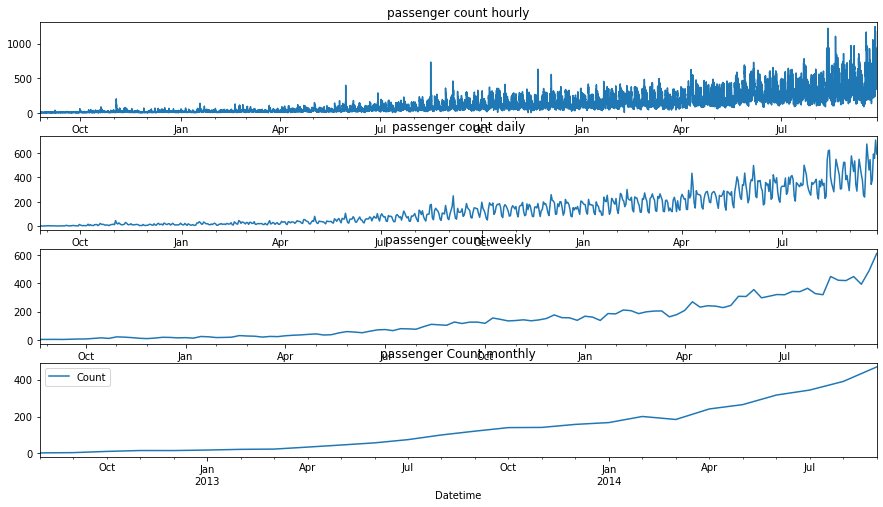

In [48]:
fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize=(15,8), title='passenger count hourly', ax=axs[0])
plt.legend(loc='best')
daily.Count.plot(figsize=(15,8), title='passenger count daily', ax=axs[1])
plt.legend(loc='best')
weekly.Count.plot(figsize=(15,8), title='passenger count weekly', ax=axs[2])
plt.legend(loc='best')
monthly.Count.plot(figsize=(15,8), title='passenger Count monthly', ax=axs[3])

plt.legend(loc='best')
plt.show()

In [49]:
daily.head()

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis. But it would be difficult to convert the monthly and weekly predictions to hourly predictions, 
as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, 
which will become very expanded process. So, we will work on the daily time series.

In [50]:
Train = daily.loc['2012-08-25':'2014-06-24']
valid = daily.loc['2014-06-25':]

Now lets lok at how Train and valid part has been divided

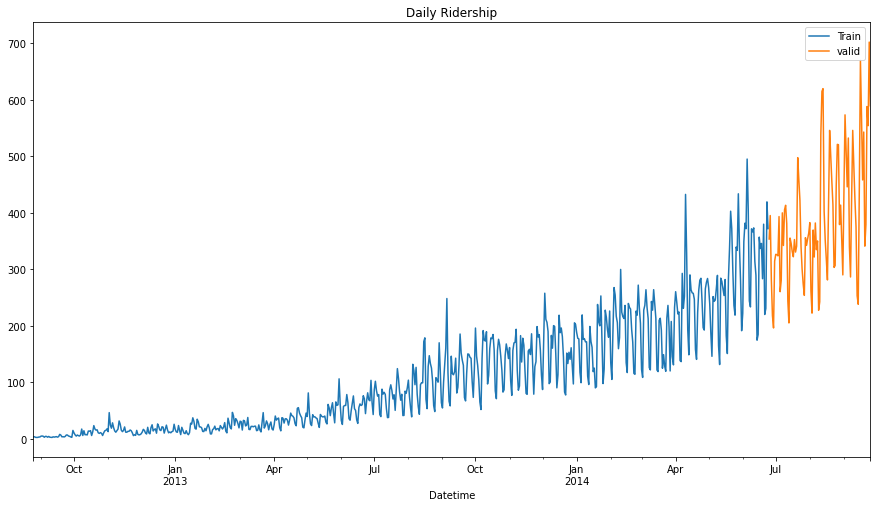

In [51]:
Train.Count.plot(figsize=(15,8), title='Daily Ridership', label='Train')
valid.Count.plot(figsize=(15,8), title='Daily Ridership', label='valid')
plt.legend(loc='best')

## Moving Average


* Now lets make prediction by taking average of previous few observation instead of taking it all.
* lets take the rolling mean of 10,20,50 and 100 days and visualize the result

In [52]:
# 
y_10 = valid.copy()

In [53]:
Train.Count.rolling(10).mean()[-1]

313.0333333333333

In [54]:
y_10['MA_10'] =  Train.Count.rolling(10).mean()[-1]

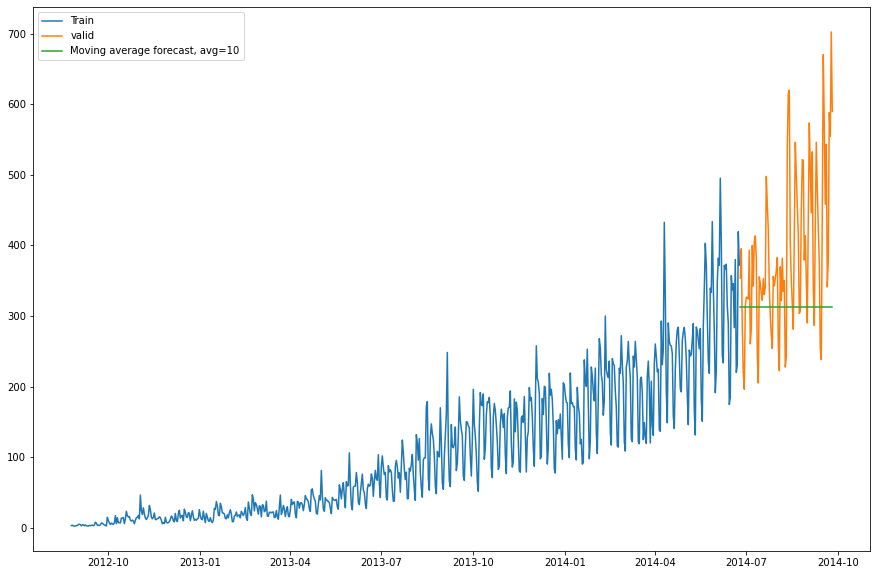

In [55]:
plt.figure(figsize=(15,10))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='valid')
plt.plot(y_10['MA_10'], label='Moving average forecast, avg=10')
plt.legend(loc='best')
plt.show()

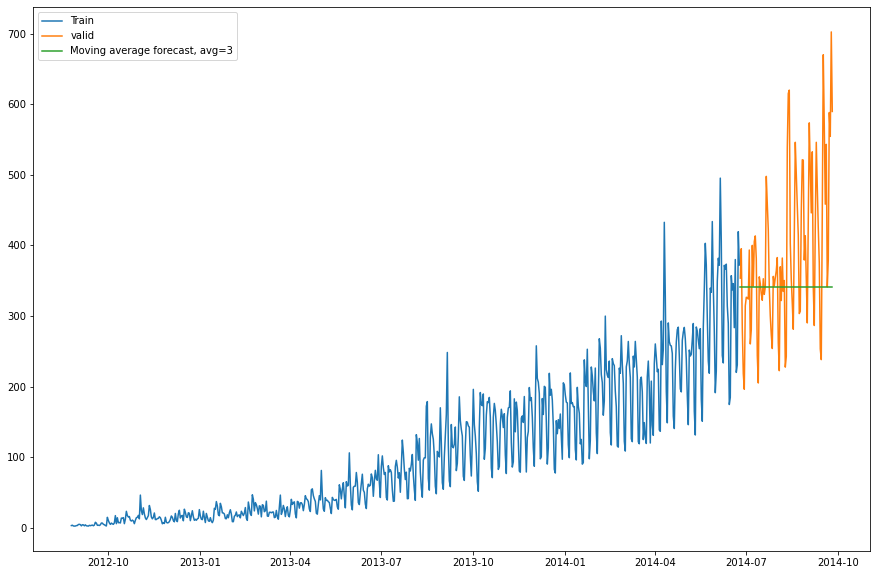

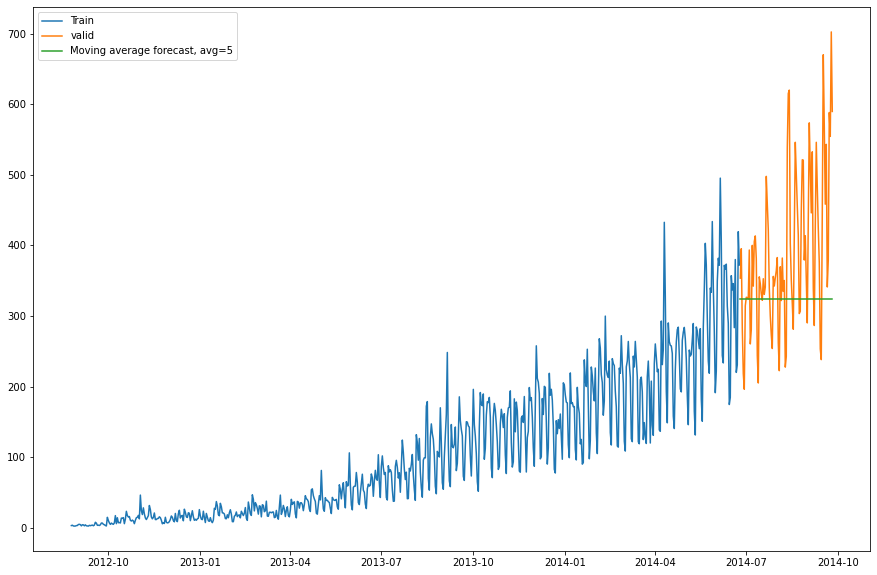

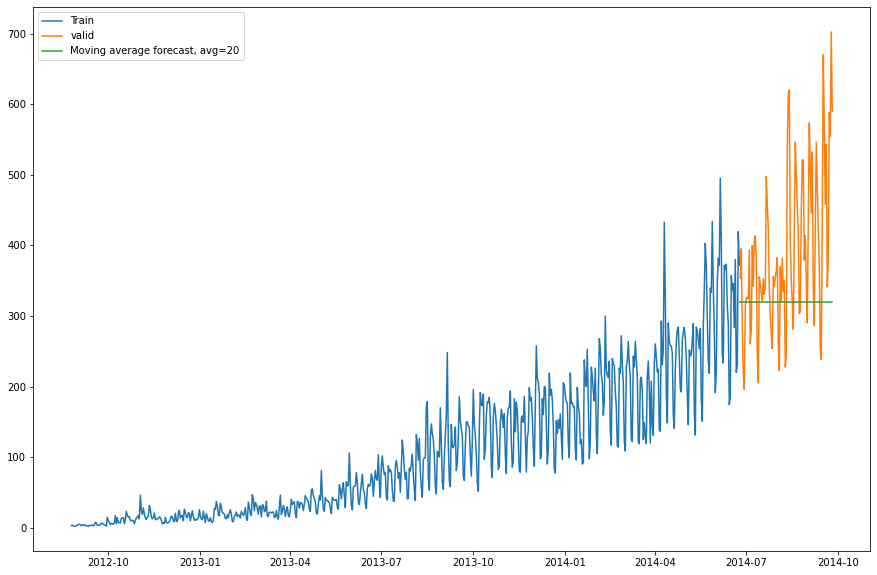

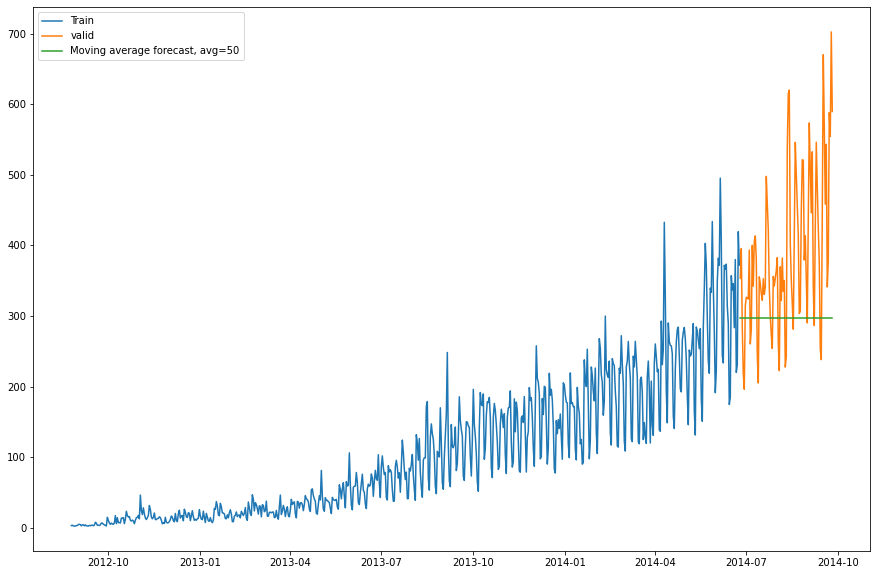

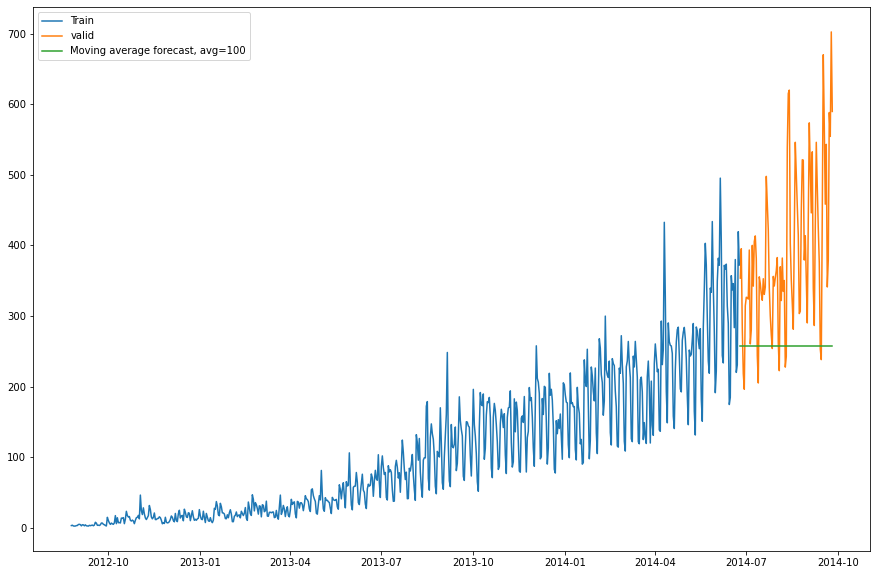

In [57]:
#lets do the above steps for different moving average
moving_averages = [3,5,20,50,100]
for i in moving_averages:
    y = valid.copy()
    ma = 'MA_'+f'{i}'
    y['MA_'+f'{i}'] =  Train.Count.rolling(i).mean()[-1]
    plt.figure(figsize=(15,10))
    plt.plot(Train['Count'], label='Train')
    plt.plot(valid['Count'], label='valid')
    plt.plot(y['MA_'+f'{i}'], label=f'Moving average forecast, avg={i}')
    plt.legend(loc='best')
    plt.show()

In [58]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(valid.Count, y_10.MA_10))
print(rms)

134.23733308950264


In [59]:
for i in moving_averages:
    y=valid.copy()
    y['ma_'+f'{i}'] = Train.Count.rolling(i).mean()[-1]
    rms = sqrt(mean_squared_error(valid.Count, y['ma_'+f'{i}']))
    print(f'rms for Moving Average {i} :', rms)

rms for Moving Average 3 : 120.64413451697209
rms for Moving Average 5 : 128.07949064131645
rms for Moving Average 20 : 130.4498497755042
rms for Moving Average 50 : 144.19175679986793
rms for Moving Average 100 : 171.78590119726593


From above you can see that more the number of values more we take for calculating our moving average the more error we are getting.

## Simple Exponential Smoothing
* In this technique, we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

In [60]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [61]:
y_avg = valid.copy()

In [62]:
fit1 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=.6, optimized = False)

C:\Users\cws\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [63]:
y_avg['SES'] = fit1.forecast(len(valid))

In [64]:
y_avg.head()

,Count,year,month,day,Hour,day of week,weekend,SES
Datetime,,,,,,,,
2014-06-25,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0,363.522492
2014-06-26,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0,363.522492
2014-06-27,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0,363.522492
2014-06-28,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0,363.522492
2014-06-29,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0,363.522492


In [65]:
rms = sqrt(mean_squared_error(valid.Count, y_avg['SES']))
rms

113.43708111884514

We can see that the fit of the model has increased as rmse has decreased.

## Holt Linear trend model
* It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
* This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.
#### First of all let us visualize the trend, seasonality and error in the series.
#### We can decompose the time series in four parts.
* Observed, which is the original time series.
* Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
* Seasonal, which tells us about the seasonality in the time series.
* Residual, which is obtained by removing any trend or seasonality in the time series.

In [66]:
import statsmodels.api as sm

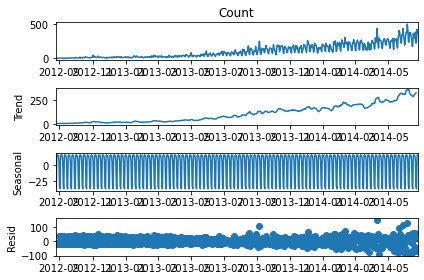

In [67]:
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

In [68]:
result

(-4.456560536856806,
 0.0002354046646766707,
 45,
 18242,
 {'1%': -3.430708525404171,
  '5%': -2.861698454786869,
  '10%': -2.5668543412994906},
 181026.8337109476)

In [69]:
fit2 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.35, smoothing_slope = 0.06)

C:\Users\cws\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-69-f7b3c34a0807>:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit2 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.35, smoothing_slope = 0.06)


In [70]:
y_holt = valid.copy()

In [71]:
y_holt['holt'] = fit2.forecast(len(valid))

In [72]:
y_holt.head()

,Count,year,month,day,Hour,day of week,weekend,holt
Datetime,,,,,,,,
2014-06-25,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0,342.020423
2014-06-26,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0,344.153586
2014-06-27,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0,346.286748
2014-06-28,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0,348.419911
2014-06-29,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0,350.553073


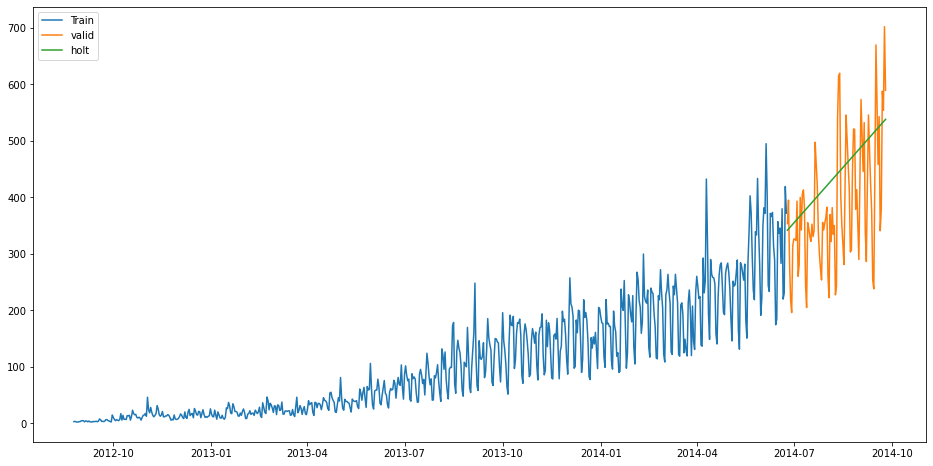

In [73]:
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='valid')
plt.plot(y_holt['holt'], label='holt')
plt.legend(loc='best')
plt.show()

In [74]:
rms = sqrt(mean_squared_error(valid.Count, y_holt['holt']))
rms

107.45020607519048

In [75]:
submission = pd.read_csv('sample_submission_LSeus50.csv')

We only need ID and count for final submission

## Now lets look at the test file

In [76]:
df_test.head()

,ID,Datetime,year,month,day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


In [77]:
# Putting datetime as index just like train data
df_test.index = df_test.Datetime

In [78]:
df_test.head()

,ID,Datetime,year,month,day,Hour
Datetime,,,,,,
2014-09-26 00:00:00,18288,2014-09-26 00:00:00,2014,9,26,0
2014-09-26 01:00:00,18289,2014-09-26 01:00:00,2014,9,26,1
2014-09-26 02:00:00,18290,2014-09-26 02:00:00,2014,9,26,2
2014-09-26 03:00:00,18291,2014-09-26 03:00:00,2014,9,26,3
2014-09-26 04:00:00,18292,2014-09-26 04:00:00,2014,9,26,4


In [79]:
# Converting to daily mean
df_test = df_test.resample('D').mean()
df_test.head()

,ID,year,month,day,Hour
Datetime,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5
2014-09-27,18323.5,2014.0,9.0,27.0,11.5
2014-09-28,18347.5,2014.0,9.0,28.0,11.5
2014-09-29,18371.5,2014.0,9.0,29.0,11.5
2014-09-30,18395.5,2014.0,9.0,30.0,11.5


### Prediction for test dataset 

In [80]:
predict = fit2.forecast(len(df_test))

In [81]:
df_test['prediction'] = predict

In [82]:
df_test.shape

(213, 6)

In [83]:
train.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [84]:
# Calculating the hour ratio of count
train['ratio'] = train['Count']/train['Count'].sum()
train.head()

,ID,Datetime,Count,year,month,day,Hour,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,7.870093e-07


In [85]:
# Grouping the Hourly ratio
temp = train.groupby(['Hour'])['ratio'].sum()
temp.head()

Hour
0    0.044287
1    0.035343
2    0.029911
3    0.024714
4    0.020802
Name: ratio, dtype: float64

In [86]:
# groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')

In [87]:
temp2 = pd.read_csv('GROUPby.csv')

In [88]:
temp2 = temp2.drop('Hour.1', axis=1)

In [89]:
temp2.head()

,Hour,ratio
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802


In [90]:
# merge df_test and test on day, month and year
merge = pd.merge(df_test, test, on=('day','month','year'), how='left')
merge

,ID_x,year,month,day,Hour_x,prediction,ID_y,Datetime,Hour_y
0,18299.5,2014.0,9.0,26.0,11.5,342.020423,18288,2014-09-26 00:00:00,0
1,18299.5,2014.0,9.0,26.0,11.5,342.020423,18289,2014-09-26 01:00:00,1
2,18299.5,2014.0,9.0,26.0,11.5,342.020423,18290,2014-09-26 02:00:00,2
3,18299.5,2014.0,9.0,26.0,11.5,342.020423,18291,2014-09-26 03:00:00,3
4,18299.5,2014.0,9.0,26.0,11.5,342.020423,18292,2014-09-26 04:00:00,4
...,...,...,...,...,...,...,...,...,...
5107,23387.5,2015.0,4.0,26.0,11.5,794.250901,23395,2015-04-26 19:00:00,19
5108,23387.5,2015.0,4.0,26.0,11.5,794.250901,23396,2015-04-26 20:00:00,20
5109,23387.5,2015.0,4.0,26.0,11.5,794.250901,23397,2015-04-26 21:00:00,21
5110,23387.5,2015.0,4.0,26.0,11.5,794.250901,23398,2015-04-26 22:00:00,22


In [91]:
merge['Hour'] = merge['Hour_y']

In [92]:
merge.head()

,ID_x,year,month,day,Hour_x,prediction,ID_y,Datetime,Hour_y,Hour
0,18299.5,2014.0,9.0,26.0,11.5,342.020423,18288,2014-09-26 00:00:00,0,0
1,18299.5,2014.0,9.0,26.0,11.5,342.020423,18289,2014-09-26 01:00:00,1,1
2,18299.5,2014.0,9.0,26.0,11.5,342.020423,18290,2014-09-26 02:00:00,2,2
3,18299.5,2014.0,9.0,26.0,11.5,342.020423,18291,2014-09-26 03:00:00,3,3
4,18299.5,2014.0,9.0,26.0,11.5,342.020423,18292,2014-09-26 04:00:00,4,4


In [93]:
merge.drop(['year','month','Datetime','Hour_x','Hour_y'], axis =1, inplace=True)

In [94]:
merge.head()

,ID_x,day,prediction,ID_y,Hour
0,18299.5,26.0,342.020423,18288,0
1,18299.5,26.0,342.020423,18289,1
2,18299.5,26.0,342.020423,18290,2
3,18299.5,26.0,342.020423,18291,3
4,18299.5,26.0,342.020423,18292,4


In [95]:
# predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='Hour', how='left')
prediction

,ID_x,day,prediction,ID_y,Hour,ratio
0,18299.5,26.0,342.020423,18288,0,0.044287
1,18299.5,26.0,342.020423,18289,1,0.035343
2,18299.5,26.0,342.020423,18290,2,0.029911
3,18299.5,26.0,342.020423,18291,3,0.024714
4,18299.5,26.0,342.020423,18292,4,0.020802
...,...,...,...,...,...,...
5107,23387.5,26.0,794.250901,23395,19,0.055627
5108,23387.5,26.0,794.250901,23396,20,0.053455
5109,23387.5,26.0,794.250901,23397,21,0.049895
5110,23387.5,26.0,794.250901,23398,22,0.050076


In [96]:
# converting the ratio to orignal scale
prediction['Count'] = prediction['prediction']*prediction['prediction']*24
prediction

,ID_x,day,prediction,ID_y,Hour,ratio,Count
0,18299.5,26.0,342.020423,18288,0,0.044287,2.807471e+06
1,18299.5,26.0,342.020423,18289,1,0.035343,2.807471e+06
2,18299.5,26.0,342.020423,18290,2,0.029911,2.807471e+06
3,18299.5,26.0,342.020423,18291,3,0.024714,2.807471e+06
4,18299.5,26.0,342.020423,18292,4,0.020802,2.807471e+06
...,...,...,...,...,...,...,...
5107,23387.5,26.0,794.250901,23395,19,0.055627,1.514003e+07
5108,23387.5,26.0,794.250901,23396,20,0.053455,1.514003e+07
5109,23387.5,26.0,794.250901,23397,21,0.049895,1.514003e+07
5110,23387.5,26.0,794.250901,23398,22,0.050076,1.514003e+07


In [97]:
prediction['ID'] = prediction['ID_y']
prediction

,ID_x,day,prediction,ID_y,Hour,ratio,Count,ID
0,18299.5,26.0,342.020423,18288,0,0.044287,2.807471e+06,18288
1,18299.5,26.0,342.020423,18289,1,0.035343,2.807471e+06,18289
2,18299.5,26.0,342.020423,18290,2,0.029911,2.807471e+06,18290
3,18299.5,26.0,342.020423,18291,3,0.024714,2.807471e+06,18291
4,18299.5,26.0,342.020423,18292,4,0.020802,2.807471e+06,18292
...,...,...,...,...,...,...,...,...
5107,23387.5,26.0,794.250901,23395,19,0.055627,1.514003e+07,23395
5108,23387.5,26.0,794.250901,23396,20,0.053455,1.514003e+07,23396
5109,23387.5,26.0,794.250901,23397,21,0.049895,1.514003e+07,23397
5110,23387.5,26.0,794.250901,23398,22,0.050076,1.514003e+07,23398


In [98]:
# submission file has onlry ID and Count
submission = prediction[['ID','Count']]
submission

,ID,Count
0,18288,2.807471e+06
1,18289,2.807471e+06
2,18290,2.807471e+06
3,18291,2.807471e+06
4,18292,2.807471e+06
...,...,...
5107,23395,1.514003e+07
5108,23396,1.514003e+07
5109,23397,1.514003e+07
5110,23398,1.514003e+07


In [99]:
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt_linear.csv', index=False)

## Holts Winter model for daily time series 
* Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.
* The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.
* One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.

In [100]:
y_winter = valid.copy()

In [101]:
fit3 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods =7, trend='add', seasonal='add').fit()

C:\Users\cws\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [102]:
y_winter['winter'] = fit3.forecast(len(valid))

In [103]:
y_winter

,Count,year,month,day,Hour,day of week,weekend,winter
Datetime,,,,,,,,
2014-06-25,353.666667,2014.0,6.0,25.0,11.5,2.0,0.0,388.150689
2014-06-26,395.250000,2014.0,6.0,26.0,11.5,3.0,0.0,369.814416
2014-06-27,282.333333,2014.0,6.0,27.0,11.5,4.0,0.0,356.082270
2014-06-28,218.250000,2014.0,6.0,28.0,11.5,5.0,1.0,247.751286
2014-06-29,196.250000,2014.0,6.0,29.0,11.5,6.0,1.0,247.096061
...,...,...,...,...,...,...,...,...
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0,288.431416
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0,428.012545
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0,419.044899


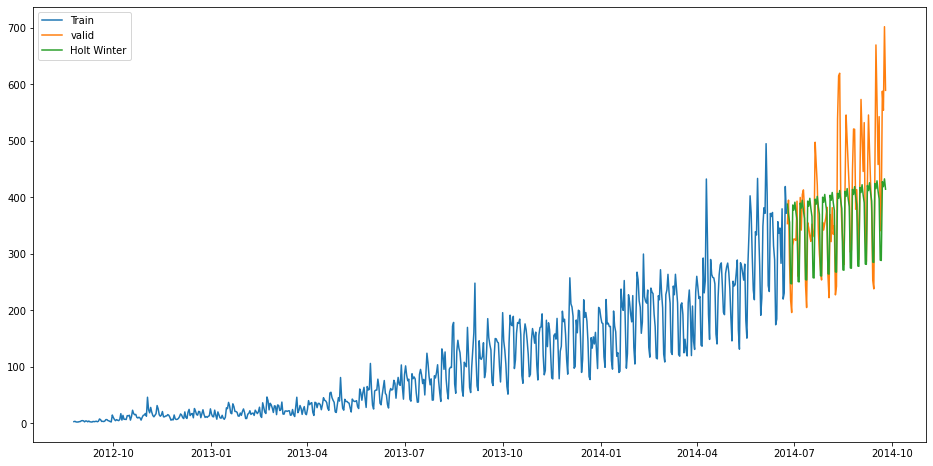

In [104]:
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='valid')
plt.plot(y_winter['winter'], label='Holt Winter')
plt.legend(loc='best')
plt.show()

In [105]:
rms = sqrt(mean_squared_error(valid.Count,y_winter.winter))
rms

82.30156765439277

### Prediction
we can see that rmse value has reduced a lot for this method. lets forecast the count for the entire dataset.

In [106]:
predict_w = fit3.forecast(len(df_test))

In [107]:
df_test['prediction'] = predict_w
df_test

,ID,year,month,day,Hour,prediction
Datetime,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,388.150689
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,369.814416
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,356.082270
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,247.751286
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,247.096061
...,...,...,...,...,...,...
2015-04-22,23291.5,2015.0,4.0,22.0,11.5,486.570965
2015-04-23,23315.5,2015.0,4.0,23.0,11.5,477.603318
2015-04-24,23339.5,2015.0,4.0,24.0,11.5,491.489076


In [108]:
train['ratio'] = train['Count']/train['Count'].sum()
train.head()

,ID,Datetime,Count,year,month,day,Hour,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,7.870093e-07


In [111]:
temp_w = pd.DataFrame(temp_w, columns=['Hour1','ratio']).to_csv('temp_w.csv')

In [117]:
temp_wh = pd.read_csv('temp_w.csv')
temp_wh.drop('Hour1', axis=1, inplace=True)

In [119]:
temp_wh.head()

,Hour,ratio
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802


In [112]:
# merge df_test and test on day, month and year
merge_w = pd.merge(df_test, test, on=('day','month','year'), how='left')
merge_w

,ID_x,year,month,day,Hour_x,prediction,ID_y,Datetime,Hour_y
0,18299.5,2014.0,9.0,26.0,11.5,388.150689,18288,2014-09-26 00:00:00,0
1,18299.5,2014.0,9.0,26.0,11.5,388.150689,18289,2014-09-26 01:00:00,1
2,18299.5,2014.0,9.0,26.0,11.5,388.150689,18290,2014-09-26 02:00:00,2
3,18299.5,2014.0,9.0,26.0,11.5,388.150689,18291,2014-09-26 03:00:00,3
4,18299.5,2014.0,9.0,26.0,11.5,388.150689,18292,2014-09-26 04:00:00,4
...,...,...,...,...,...,...,...,...,...
5107,23387.5,2015.0,4.0,26.0,11.5,459.420657,23395,2015-04-26 19:00:00,19
5108,23387.5,2015.0,4.0,26.0,11.5,459.420657,23396,2015-04-26 20:00:00,20
5109,23387.5,2015.0,4.0,26.0,11.5,459.420657,23397,2015-04-26 21:00:00,21
5110,23387.5,2015.0,4.0,26.0,11.5,459.420657,23398,2015-04-26 22:00:00,22


In [113]:
merge_w['Hour']=merge_w['Hour_y']
merge_w['ID']=merge_w['ID_y']
merge_w = merge_w[['day','ID','Hour','prediction']]

In [114]:
merge_w

,day,ID,Hour,prediction
0,26.0,18288,0,388.150689
1,26.0,18289,1,388.150689
2,26.0,18290,2,388.150689
3,26.0,18291,3,388.150689
4,26.0,18292,4,388.150689
...,...,...,...,...
5107,26.0,23395,19,459.420657
5108,26.0,23396,20,459.420657
5109,26.0,23397,21,459.420657
5110,26.0,23398,22,459.420657


In [120]:
# predicting by merging merge and temp2
prediction = pd.merge(merge_w, temp_wh, on='Hour', how='left')
prediction

,day,ID,Hour,prediction,ratio
0,26.0,18288,0,388.150689,0.044287
1,26.0,18289,1,388.150689,0.035343
2,26.0,18290,2,388.150689,0.029911
3,26.0,18291,3,388.150689,0.024714
4,26.0,18292,4,388.150689,0.020802
...,...,...,...,...,...
5107,26.0,23395,19,459.420657,0.055627
5108,26.0,23396,20,459.420657,0.053455
5109,26.0,23397,21,459.420657,0.049895
5110,26.0,23398,22,459.420657,0.050076


In [121]:
# converting the ratio to orignal scale
prediction['Count'] = prediction['prediction']*prediction['prediction']*24
prediction

,day,ID,Hour,prediction,ratio,Count
0,26.0,18288,0,388.150689,0.044287,3.615863e+06
1,26.0,18289,1,388.150689,0.035343,3.615863e+06
2,26.0,18290,2,388.150689,0.029911,3.615863e+06
3,26.0,18291,3,388.150689,0.024714,3.615863e+06
4,26.0,18292,4,388.150689,0.020802,3.615863e+06
...,...,...,...,...,...,...
5107,26.0,23395,19,459.420657,0.055627,5.065616e+06
5108,26.0,23396,20,459.420657,0.053455,5.065616e+06
5109,26.0,23397,21,459.420657,0.049895,5.065616e+06
5110,26.0,23398,22,459.420657,0.050076,5.065616e+06


In [122]:
# submission file has onlry ID and Count
submission = prediction[['ID','Count']]
submission

,ID,Count
0,18288,3.615863e+06
1,18289,3.615863e+06
2,18290,3.615863e+06
3,18291,3.615863e+06
4,18292,3.615863e+06
...,...,...
5107,23395,5.065616e+06
5108,23396,5.065616e+06
5109,23397,5.065616e+06
5110,23398,5.065616e+06


In [123]:
pd.DataFrame(submission, columns = ['ID','Count']).to_csv('Holt_winter.csv', index=False)